In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '16'
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
import random as rdm
# import multiprocessing
# from multiprocessing import pool
# from joblib import Parallel, delayed
# from mpi4py import MPI
# from functools import reduce
import time

# comm = MPI.COMM_WORLD
# rank = comm.rank
# size = comm.size

In [2]:
# start_time=time.time()
# #test script:
# a = np.random.randn(5000, 50000)
# b = np.random.randn(50000, 5000)
# ran_time=time.time()-start_time
# print("time to complete random matrix generation was %s seconds" % ran_time)
# np.dot(a, b) #this line should be multi-threaded
# print("time to complete dot was %s seconds" % (time.time() - start_time - ran_time))

# Generate POVMs

In [3]:
def generateM(povm):
    Ms = []
    if povm == '4Pauli':
        
        # Eigenvectors
        up = np.array([1+0j,0+0j], dtype='complex128')
        plus = np.array([1+0j,1+0j], dtype='complex128') / np.sqrt(2)
        right = np.array([1+0j,0+1j], dtype='complex128') / np.sqrt(2)
        
        # 4-Pauli POVMs for a single qubit
        M0 = np.outer(up, np.conj(up)) / 3
        M1 = np.outer(plus, np.conj(plus)) / 3
        M2 = np.outer(right, np.conj(right)) / 3
        M3 = np.eye(2, dtype='complex128') - M0 - M1 - M2
        
        Ms = [M0, M1, M2, M3]
        
    elif povm == 'Tetra':
        
        I = np.array([[1,0],[0,1]], dtype='complex128')
        X = np.array([[0, 1],[1, 0]], dtype='complex128')
        Z = np.array([[1, 0],[0, -1]], dtype='complex128')
        Y = np.array([[0, -1j],[1j, 0]], dtype='complex128')
        
        # Tetra
        v1 = np.array([0, 0, 1])
        M0 = (I + v1[0]*X + v1[1]*Y + v1[2]*Z)/4
        v2 = np.array([2*np.sqrt(2)/3, 0, -1/3])
        M1 = (I + v2[0]*X + v2[1]*Y + v2[2]*Z)/4
        v3 = np.array([-np.sqrt(2)/3, np.sqrt(2)/3, -1/3])
        M2 = (I + v3[0]*X + v3[1]*Y + v3[2]*Z)/4
        v4 = np.array([-np.sqrt(2)/3, -np.sqrt(2)/3, -1/3])
        M3 = (I + v4[0]*X + v4[1]*Y + v4[2]*Z)/4
        
        Ms = [M0, M1, M2, M3]
    elif povm == 'Pauli':
        
        def pXp(theta,phi):

            return np.array([[ np.cos(theta/2.0)**2, np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(-1j*phi)],\
                         [ np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(1j*phi), np.sin(theta/2.0)**2 ]])
        
        def mXm(theta,phi):

            return np.array([[ np.sin(theta/2.0)**2, -np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(-1j*phi)],\
                         [ -np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(1j*phi), np.cos(theta/2.0)**2 ]])
        
        Ps = np.array([1./3., 1./3., 1./3., 1./3.,1./3.,1./3.]);
        theta = np.pi/2.0
        M0 = Ps[0]*pXp(theta,0.0)
        M1 = Ps[1]*mXm(theta,0.0)
        M2 = Ps[2]*pXp(theta,np.pi/2.0)
        M3 = Ps[3]*mXm(theta,np.pi/2.0)
        M4 = Ps[4]*pXp(0.0,0.0)
        M5 = Ps[5]*mXm(0,0.0)
        
        Ms = [M0, M1, M2, M3, M4, M5]
        
    elif povm == 'Pauli_rebit':
        def pXp(theta,phi):

            return np.array([[ np.cos(theta/2.0)**2, np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(-1j*phi)],\
                         [ np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(1j*phi), np.sin(theta/2.0)**2 ]])
        
        def mXm(theta,phi):

            return np.array([[ np.sin(theta/2.0)**2, -np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(-1j*phi)],\
                         [ -np.cos(theta/2.0)*np.sin(theta/2.0)*np.exp(1j*phi), np.cos(theta/2.0)**2 ]])
        
        # pauli_rebit
        Ps = np.array([1./2., 1./2., 1./2., 1./2.])
        theta = np.pi/2.0
        M0 = Ps[0]*pXp(theta,0.0)
        M1 = Ps[1]*mXm(theta,0.0)
        M2 = Ps[2]*pXp(0.0,0.0)
        M3 = Ps[3]*mXm(0,0.0)
        
        Ms = [M0, M1, M2, M3]
    elif povm == 'Trine':
        
        I = np.array([[1,0],[0,1]], dtype='complex128')
        X = np.array([[0, 1],[1, 0]], dtype='complex128')
        Z = np.array([[1, 0],[0, -1]], dtype='complex128')
        Y = np.array([[0, -1j],[1j, 0]], dtype='complex128')
        
        # Trine
        phi0 = 0
        phi1 = 2*np.pi/3
        phi2 = 2*2*np.pi/3
        M0 = 0.5*(I + np.cos(phi0)*Z + np.sin(phi0)*X)*2/3.0
        M1 = 0.5*(I + np.cos(phi1)*Z + np.sin(phi1)*X)*2/3.0
        M2 = 0.5*(I + np.cos(phi2)*Z + np.sin(phi2)*X)*2/3.0
        
        Ms = [M0, M1, M2]
    elif povm == 'Psi2':
        M0 = np.array([[1,0],[0,0]], dtype='complex128')
        M1 = np.array([[0,0],[0,1]], dtype='complex128')
        Ms = [M0, M1]
    elif povm == 'test':
        M0 = np.array([[1,1j],[-1j,0]], dtype='complex128')
        M1 = np.array([[0,-1j],[1j,1]], dtype='complex128')
        Ms = [M0, M1]
    elif povm == 'test2':
        M0 = np.array([[1,1j],[-1j,0]], dtype='complex128')
        M1 = np.array([[0,-2j],[2j,0]], dtype='complex128')
        M2 = np.array([[0,1j],[-1j,1]], dtype='complex128')
        Ms = [M0, M1, M2]
    else:
        raise ValueError('POVM not defined.')
    return Ms

# training set
Our training set is a simple Gaussian distribution



Only need to change POVM and num_bit.

Parameters later will change automatically.

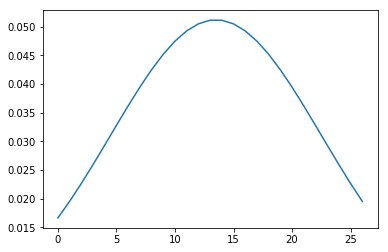

In [4]:
POVM = 'Trine' # select from 4Pauli, Tetra, Pauli, Pauli_rebit, Trine, Psi2
Ms = generateM(POVM)
Mlist = Ms[:] # make a copy
num_M = len(Ms)

def gaussian_pdf(num_bit, mu, sigma):
    '''get gaussian distribution function'''
    x = np.arange(num_M**num_bit)     # changed to num_M
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()


num_bit = 3
pg = gaussian_pdf(num_bit, mu=num_M**num_bit/2, sigma=num_M**(num_bit-1))  
plt.plot(pg)
plt.show()

# Build Circuits
## Building Blocks
Define matrix representations of operations using scipy sparse matrices.
They are grouped to become a layer in a circuit, this layer can be `ArbitraryRotation` or `CNOTEntangler`.
Which are used as our basic building blocks of our `Born Machines`.

In [5]:
######  Pauli Matrices  ########
I2 = sps.eye(2).tocsr()
sx = sps.csr_matrix([[0,1],[1,0.]])
sy = sps.csr_matrix([[0,-1j],[1j,0.]])
sz = sps.csr_matrix([[1,0],[0,-1.]])

p0 = (sz + I2) / 2   #projection operator to |0><0|
p1 = (-sz + I2) / 2

# single bit rotation matrices
def _ri(si, theta):
    return np.cos(theta/2.)*I2 - 1j*np.sin(theta/2.)*si

def rot(t1, t2, t3):
    '''
    a general rotation gate rz(t3)rx(r2)rz(t1).

    Args:
        t1, t2, t3 (float): three angles.

    Returns:
        2x2 csr_matrix: rotation matrix.
    '''
    return _ri(sz, t3).dot(_ri(sx, t2)).dot(_ri(sz, t1))

# multiple bit construction
def CNOT(ibit, jbit, n):
    '''
    CNOT gate
    
    Args:
        ibit (int): control bit.
        jbit (int): controled bit.
        n (int): total number of qubits.
        
    Returns:
        4x4 csr_matrix: CNOT matrix.
    '''
    res = _([p0, I2], [ibit, jbit], n)
    res = res + _([p1, sx], [ibit, jbit], n)
    return res

def _(ops, locs, n):
    '''
    Compile operators into specific Hilbert space.

    notice the last bit is the high end bit!

    Args:
        ops (list): list of single bit operators.
        locs (list): list of positions.
        n (int): total number of bits.

    Returns:
        csr_matrix: resulting matrix.
    '''
    if np.ndim(locs) == 0:
        locs = [locs]
    if not isinstance(ops, (list, tuple)):
        ops = [ops]
    locs = np.asarray(locs)
    locs = n - locs
    order = np.argsort(locs)
    locs = np.concatenate([[0], locs[order], [n + 1]])
    return _wrap_identity([ops[i] for i in order], np.diff(locs) - 1)


def _wrap_identity(data_list, num_bit_list):
    if len(num_bit_list) != len(data_list) + 1:
        raise Exception()

    res = sps.eye(2**num_bit_list[0])
    for data, nbit in zip(data_list, num_bit_list[1:]):
        res = sps.kron(res, data)
        res = sps.kron(res, sps.eye(2**nbit, dtype='complex128'))
    return res


def initial_wf(num_bit):
    '''initial wave function |00...0>.'''
    wf = np.zeros(2**num_bit, dtype='complex128')
    wf[0] = 1.
    return wf

In [6]:
class ArbitraryRotation(object):
    '''Arbitrary rotation gate'''
    def __init__(self, num_bit):
        self.num_bit = num_bit
        # mask is used to filter out some irrelevant (marked False) parameters
        self.mask = np.array([True] * (3*num_bit), dtype='bool')

    @property
    def num_param(self):
        return self.mask.sum()

    def tocsr(self, theta_list):
        '''transform this block to a sequence of csr_matrices.'''
        theta_list_ = np.zeros(3*self.num_bit)
        theta_list_[self.mask] = theta_list
        rots = [rot(*ths) for ths in theta_list_.reshape([self.num_bit,3])]
        res = [_([r], [i], self.num_bit) for i,r in enumerate(rots)]
        return res

class CNOTEntangler(object):
    '''
    CNOT Entangler Layer.
    
    Args:
        pairs (list): a list of tuples to represent connections.
    '''
    def __init__(self, num_bit, pairs):
        self.num_bit = num_bit
        self.pairs = pairs

    @property
    def num_param(self):
        return 0

    def tocsr(self, theta_list):
        '''transform this block to a sequence of csr_matrices.'''
        i, j = self.pairs[0]
        res = CNOT(i, j, self.num_bit)
        for i, j in self.pairs[1:]:
            res = CNOT(i,j,self.num_bit).dot(res)
        res.eliminate_zeros()
        return [res]

# Circuit
A circuit is consist of queued layers, here this data structure is `BlockQueue`. A `BlockQueue` uses `theta_last` and `memo` attributes to cache sparse operators, this will accelerate simulation significantly.

In [7]:
class BlockQueue(list):
    '''
    Block Queue that keep track of theta_list changing history, for fast update.
    
    Attributes:
        theta_last (1darray): the cached circuit parameters.
        memo (list): cached sparse matrices for layers.
    '''
    def __init__(self, *args):
        list.__init__(self, *args)
        self.theta_last = None
        self.memo = None

    def __call__(self, qureg, theta_list):
        '''
        Apply operations on vector basis: qureg. This operation changes vector inplace.
        
        Args:
            qureg (1darray): vector basis.
            theta_list (1darray): circuit parameters:
        '''
        # cache? if theta_list change <= 1 parameters, then don't touch memory.
        remember = self.theta_last is None or (abs(self.theta_last-theta_list)>1e-12).sum() > 1

        mats = []
        theta_last = self.theta_last
        if remember:
            self.theta_last = theta_list.copy()

        qureg_ = qureg
        for iblock, block in enumerate(self):
            # generate or use a block matrix
            num_param = block.num_param
            theta_i, theta_list = np.split(theta_list, [num_param])
            if theta_last is not None:
                theta_o, theta_last = np.split(theta_last, [num_param])
            if self.memo is not None and (num_param==0 or np.abs(theta_i-theta_o).max()<1e-12):
                # use data cached in memory
                mat = self.memo[iblock]
            else:
                if self.memo is not None and not remember:
                    # update the changed gate, but not touching memory.
                    mat = _rot_tocsr_update1(block, self.memo[iblock], theta_o, theta_i)
                else:
                    # regenerate one
                    mat = block.tocsr(theta_i)
            for mat_i in mat:
                qureg_ = mat_i.dot(qureg_)
            mats.append(mat)

        if remember:
            # cache data
            self.memo = mats
        # update register
        qureg[...] = qureg_
        np.testing.assert_(len(theta_list)==0)
        
    @property
    def num_bit(self):
        return self[0].num_bit

    @property
    def num_param(self):
        return sum([b.num_param for b in self])

def _rot_tocsr_update1(layer, old, theta_old, theta_new):
    '''
    rotation layer csr_matrices update method.
    
    Args:
        layer (ArbitraryRotation): rotation layer.
        old (csr_matrix): old matrices.
        theta_old (1darray): old parameters.
        theta_new (1darray): new parameters.

    Returns:
        list of csr_matrix: new rotation matrices after the theta changed.
    '''
    idiff_param = np.where(abs(theta_old-theta_new)>1e-12)[0].item()
    idiff = np.where(layer.mask)[0][idiff_param]

    # get rotation parameters
    isite = idiff//3
    theta_list_ = np.zeros(3*layer.num_bit)
    theta_list_[layer.mask] = theta_new
    
    new = old[:]
    new[isite] = _(rot(*theta_list_[isite*3:isite*3+3]), isite, layer.num_bit)
    return new

In [8]:
def get_nn_pairs(num_bit):
    '''get nearest neighbor pairs.'''
    res = []
    for inth in range(2):
        for i in range(inth, num_bit, 2):
            res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
    return res

def get_demo_circuit(num_bit, depth, pairs):
    '''Get the circuit used for demo'''
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbitraryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))

    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [9]:
# let's see how this circuit look like
depth = 12  # was 6
pairs = get_nn_pairs(num_bit)
circuit = get_demo_circuit(num_bit, depth, pairs)
print(circuit)

[<__main__.ArbitraryRotation object at 0x00000225E9127B38>, <__main__.CNOTEntangler object at 0x00000225E91270B8>, <__main__.ArbitraryRotation object at 0x00000225E91279B0>, <__main__.CNOTEntangler object at 0x00000225E9127828>, <__main__.ArbitraryRotation object at 0x00000225E9127860>, <__main__.CNOTEntangler object at 0x00000225E9127D68>, <__main__.ArbitraryRotation object at 0x00000225E9127470>, <__main__.CNOTEntangler object at 0x00000225E91274A8>, <__main__.ArbitraryRotation object at 0x00000225E9127A20>, <__main__.CNOTEntangler object at 0x00000225E91274E0>, <__main__.ArbitraryRotation object at 0x00000225E9127278>, <__main__.CNOTEntangler object at 0x00000225E9127780>, <__main__.ArbitraryRotation object at 0x00000225E9127AC8>, <__main__.CNOTEntangler object at 0x00000225E9127710>, <__main__.ArbitraryRotation object at 0x00000225E91277B8>, <__main__.CNOTEntangler object at 0x00000225E9127B00>, <__main__.ArbitraryRotation object at 0x00000225E9127A58>, <__main__.CNOTEntangler obje

In [10]:
# let's see how this circuit works
# rotating the last bit along x axis by pi/2.
theta_list = np.zeros(circuit.num_param)
print(theta_list)
theta_list[-1] = np.pi/2

wf = initial_wf(num_bit)
circuit(wf, theta_list)

# now you see the last bit is the high end bit!
print(wf)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.70710678+0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        -0.70710678j 0.        +0.j
 0.        +0.j         0.        +0.j        ]


# MMD Loss Function
As a reminder
\begin{align}
    \mathcal{L} =&  \left\|\sum_{x} p_\theta(x) \phi(x)- \sum_{x} \pi(x) \phi(x)  \right\|^2 \\
    =&\langle K(x,y)\rangle_{x\sim p_\theta, y\sim p_\theta}-2\langle K(x,y)\rangle_{x\sim p_\theta,y\sim \pi}+\langle K(x, y)\rangle_{x\sim \pi,y\sim \pi}
\end{align}


In [11]:
class RBFMMD2(object):
    '''
    MMD^2 with RBF (Gaussian) kernel.
    
    Args:
        sigma_list (list): a list of bandwidths.
        basis (1darray): defininng space.
      
    Attributes:
        K (2darray): full kernel matrix, notice the Hilbert is countable.
    '''
    def __init__(self, sigma_list, basis):
        self.sigma_list = sigma_list
        self.basis = basis
        self.K = mix_rbf_kernel(basis, basis, self.sigma_list)

    def __call__(self, px, py):
        '''
        Args:
            px (1darray, default=None): probability for data set x, used only when self.is_exact==True.
            py (1darray, default=None): same as px, but for data set y.

        Returns:
            float: loss.
        '''
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        '''
        expectation value of kernel function.
        
        Args:
            px (1darray): the first PDF.
            py (1darray): the second PDF.
            
        Returns:
            float: kernel expectation.
        '''
        return px.dot(self.K).dot(py)

def mix_rbf_kernel(x, y, sigma_list):
    '''
    multi-RBF kernel.
    
    Args:
        x (1darray|2darray): the collection of samples A.
        x (1darray|2darray): the collection of samples B.
        sigma_list (list): a list of bandwidths.
        
    Returns:
        2darray: kernel matrix.
    '''
    ndim = x.ndim
    if ndim == 1:
        exponent = np.abs(x[:, None] - y[None, :])**2
    elif ndim == 2:
        exponent = ((x[:, None, :] - y[None, :, :])**2).sum(axis=2)
    else:
        raise
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

In [12]:
hndim = num_M**num_bit
# mmd loss
mmd = RBFMMD2(sigma_list=[0.25,4], basis=np.arange(num_M**num_bit))   # changed to num_M

# when exact match, MMD loss should be 0, e.g. two gaussians
print('Exact Match -> MMD = %.4f'%mmd(pg, pg))
# when not match, loss is not zero
prand = np.random.random(len(pg))
print('Not Match -> MMD = %.4f'%mmd(prand/prand.sum(), pg))

Exact Match -> MMD = 0.0000
Not Match -> MMD = 0.0461


# Tensorproduct of matrices

In [13]:
# make tensor product of POVMs
def tensorproduct(matrix1, matrix2):
    dim = matrix1.shape[0] * matrix2.shape[0]
    
    # has to reverse the order otherwise doesn't work
    return np.tensordot(matrix2, matrix1, axes = 0).swapaxes(1, 2).reshape(dim, dim)

In [14]:
for i in range(num_bit - 1):  # minus one because we initialized above
    Mlisttemp = []
    for m2 in Mlist:
        for m1 in Ms:
            Mlisttemp.append(tensorproduct(m1, m2))
    Mlist = Mlisttemp
# rdm.shuffle(Mlist)

In [15]:
# expectation value of POVMs, i.e. probabilities
def probability(wavefunction):
  problist = []
  for m in Mlist:
    problist.append(np.real(np.conj(wavefunction) @ m @ wavefunction)) # wf.H@M@wf
  return np.array(problist)


# Build The Gradient training framework for Born Machine
The gradient of MMD loss is
\begin{eqnarray}
        \frac{\partial \mathcal{L}}{\partial \theta_l^i} &=&\langle{K(x,y)}\rangle_{x\sim p_{\theta^+}, y\sim p_\theta}-\langle {K(x,y)}\rangle_{x\sim p_{\theta^-},y\sim p_\theta}\\
        &-&\langle K(x,y)\rangle_{x\sim p_{\theta^+},y\sim \pi}+\langle {K(x,y)}\rangle_{x\sim p_{\theta^-},y\sim \pi}.
\end{eqnarray}

In [16]:
class QCBM(object):
    '''
    Quantum Circuit Born Machine framework,

    Args:
        circuit (BlockQueue): the circuit architechture.
        mmd (RBFMMD2): maximum mean discrepancy.
        p_data (1darray): data probability distribution in computation basis.
        batch_size (int|None): introducing sampling error, None for no sampling error.
    '''
    def __init__(self, circuit, mmd, p_data, batch_size=None):
        self.circuit = circuit
        self.mmd = mmd
        self.p_data = p_data
        self.batch_size = batch_size

    @property
    def depth(self):
        '''defined by the number of entanglers'''
        return (len(self.circuit)-1)//2

    def pdf(self, theta_list):
        '''
        get probability distribution function.
        
        Args:
            theta_list (1darray): circuit parameters.
            
        Returns:
            1darray: probability distribution function.
        '''
        wf = initial_wf(self.circuit.num_bit)
        self.circuit(wf, theta_list)
        pl = probability(wf)  # changed
        # introducing sampling error
        # if self.batch_size is not None:
        #     pl = prob_from_sample(sample_from_prob(np.arange(len(pl)), pl, self.batch_size),
        #             len(pl))
        return pl

    def mmd_loss(self, theta_list):
        '''get the loss'''
        # get and cahe probability distritbution of Born Machine
        self._prob = self.pdf(theta_list)
        # use wave function to get mmd loss
        return self.mmd(self._prob, self.p_data)

    def gradient(self, theta_list):
        '''
        cheat and get gradient.
        '''
        dim = theta_list.size
        prob = self.pdf(theta_list)
        grad = np.zeros(dim)
        for i in range(dim):
            # pi/2 phase
            theta_list[i] += np.pi/2.
            prob_pos = self.pdf(theta_list)
            # -pi/2 phase
            theta_list[i] -= np.pi
            prob_neg = self.pdf(theta_list)
            # recover
            theta_list[i] += np.pi/2.

            grad_pos = self.mmd.kernel_expect(prob, prob_pos) - self.mmd.kernel_expect(prob, prob_neg)
            grad_neg = self.mmd.kernel_expect(self.p_data, prob_pos) - self.mmd.kernel_expect(self.p_data, prob_neg)
            grad[i] = grad_pos - grad_neg
        return grad
    

#     def _gradient(self, theta_list, i):
#         '''
#         helper function for gradient
#         '''
#         prob = self.pdf(theta_list)
#         # pi/2 phase
#         theta_list[i] += np.pi/2.
#         prob_pos = self.pdf(theta_list)
#         # -pi/2 phase
#         theta_list[i] -= np.pi
#         prob_neg = self.pdf(theta_list)
#         # recover
#         theta_list[i] += np.pi/2.
        
#         grad_pos = self.mmd.kernel_expect(prob, prob_pos) - self.mmd.kernel_expect(prob, prob_neg)
#         grad_neg = self.mmd.kernel_expect(self.p_data, prob_pos) - self.mmd.kernel_expect(self.p_data, prob_neg)
#         print(i)
#         return grad_pos - grad_neg
    
#     def gradient(self, theta_list):
#         '''
#         parallelized calculation.
#         '''
#         QCBM_list = [QCBM(self.circuit, self.mmd, self.p_data, self.batch_size) for i in range(len(theta_list))]
#         grad = Parallel(n_jobs = 16)(delayed(QCBM_list[i]._gradient)(theta_list, i) for i in range(len(theta_list)))
#         return np.array(grad)

    def gradient_numerical(self, theta_list, delta=1e-2):
        '''
        numerical differenciation.
        '''
        grad = []
        for i in range(len(theta_list)):
            theta_list[i] += delta/2.
            loss_pos = self.mmd_loss(theta_list)
            theta_list[i] -= delta
            loss_neg = self.mmd_loss(theta_list)
            theta_list[i] += delta/2.

            grad_i = (loss_pos - loss_neg)/delta
            grad.append(grad_i)
        return np.array(grad)
    
def sample_from_prob(x, pl, num_sample):
    '''
    sample x ~ pl.
    '''
    pl = 1. / pl.sum() * pl
    indices = np.arange(len(x))
    res = np.random.choice(indices, num_sample, p=pl)
    return np.array([x[r] for r in res])


def prob_from_sample(dataset, hndim):
    '''
    emperical probability from data.
    '''
    p_data = np.bincount(dataset, minlength=hndim)
    p_data = p_data / float(np.sum(p_data))
    return p_data

In [17]:
# Born Machine
bm = QCBM(circuit, mmd, pg, batch_size=None)  # exact version

In [18]:
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
print('MMD loss for Initial Circuit = %.4f'%bm.mmd_loss(theta_list))

MMD loss for Initial Circuit = 0.0645


In [19]:
# gradient test
# these two gradients should match.
start_time = time.time()
g1 = bm.gradient(theta_list)
print(g1)
print(time.time()-start_time)
g2 = bm.gradient_numerical(theta_list)
print(g2)

[ 0.02470592 -0.01321196 -0.00278476  0.00777349 -0.04527736 -0.00461721
  0.01492215 -0.01152326  0.02948413  0.01483853  0.02796204  0.01158434
 -0.01988387 -0.05124786 -0.01980013 -0.03589226 -0.0055778  -0.0259877
  0.02246559 -0.02201618  0.03385894 -0.03012661 -0.02348273  0.02004842
 -0.01535567 -0.01615764 -0.05800054 -0.04013214 -0.00521458 -0.00670358
 -0.01035313 -0.00119411  0.06099548 -0.02689152  0.0585099  -0.00898873
  0.01581775  0.02825762  0.03616187  0.06567542 -0.02803382 -0.02204417
  0.00477836 -0.01075898 -0.01481709 -0.04784518  0.03192089 -0.0365617
  0.01096927  0.00948586 -0.01424005  0.03251693  0.04411393 -0.02657846
  0.03829686 -0.00249158  0.01412878 -0.05474176 -0.00056721  0.01574468
 -0.00352444 -0.05097928 -0.00704948  0.05914882 -0.05998069 -0.03285586
  0.00484127  0.02830234  0.01330451 -0.01216034 -0.00915161  0.01773955
  0.0213645   0.01616967 -0.01129001 -0.03291056 -0.0052278  -0.02464865
 -0.06286241 -0.01020031 -0.02988338 -0.00367888  0.0

# Training
In this basic introduction, I prepaired classical training method like `Adam` and `L-BFGS-B` (as well as other methods supported by scipy).

In [20]:
  def train(bm, theta_list, method, max_iter=1000, step_rate=0.1):
    '''
    train a Born Machine.
    
    Args:
        bm (QCBM): quantum circuit born machine training strategy.
        theta_list (1darray): initial parameters.
        method ('Adam'|'L-BFGS-B'):
            * L-BFGS-B: efficient, but not noise tolerant.
            * Adam: noise tolerant.
        max_iter (int): maximum allowed number of iterations.
        step_rate (float): learning rate for Adam optimizer.
        
    Returns:
        (float, 1darray): final loss and parameters.
    '''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))
        
    theta_list = np.array(theta_list)
    if method == 'Adam':
        try:
            from climin import Adam
        except:
            !pip install git+https://github.com/BRML/climin.git
            from climin import Adam
        optimizer = Adam(wrt=theta_list, fprime=bm.gradient,step_rate=step_rate)
        for info in optimizer:
            callback(theta_list)
            if step[0] == max_iter:
                break
        return bm.mmd_loss(theta_list), theta_list
    else:
        from scipy.optimize import minimize
        res = minimize(bm.mmd_loss, x0=theta_list,
                       method=method, jac = bm.gradient, tol=1e-12,
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-10, 'ftol':0},
                       callback=callback,
                       )
        return res.fun, res.x

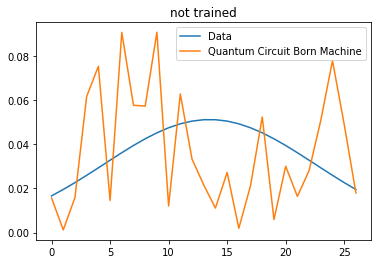

In [21]:
# random initial parameter
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
pl = bm.pdf(theta_list)
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Quantum Circuit Born Machine'])
plt.title('not trained')
plt.show()

In [22]:
loss, theta_list = train(bm, theta_list, 'L-BFGS-B', max_iter=10)
for i in range(100):
    print(i)
    loss, theta_list = train(bm, theta_list, 'L-BFGS-B', max_iter=10)
pl = bm.pdf(theta_list)

# display training result
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Quantum Circuit Born Machine'])
plt.title('trained')
plt.show()

step = 1, loss = 0.05633687677938265
step = 2, loss = 0.04239376036364301
step = 3, loss = 0.0360537394584642
step = 4, loss = 0.031198041972580935
step = 5, loss = 0.023262935232996718
step = 6, loss = 0.01881314236055696
step = 7, loss = 0.014692001093206633
step = 8, loss = 0.01353012809649357
step = 9, loss = 0.012775472788842406
step = 10, loss = 0.0117990976988063
0
step = 1, loss = 0.011545007797179166
step = 2, loss = 0.011375361276615082
step = 3, loss = 0.010866228193336576
step = 4, loss = 0.010645867151458734
step = 5, loss = 0.010490469573732602
step = 6, loss = 0.009997747689769666
step = 7, loss = 0.009714445738761545
step = 8, loss = 0.00915948419849322
step = 9, loss = 0.00802444389449299
step = 10, loss = 0.007398605196010561
1
step = 1, loss = 0.007174428233594389
step = 2, loss = 0.006972023321797106
step = 3, loss = 0.006853927674347615
step = 4, loss = 0.006740941976568188
step = 5, loss = 0.00665729102605413
step = 6, loss = 0.006562388146905492
step = 7, loss = 

KeyboardInterrupt: 

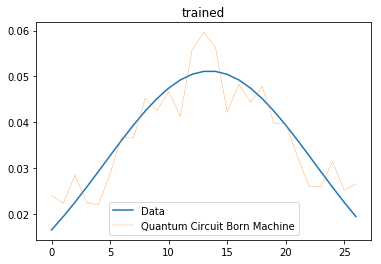

In [24]:
pl = bm.pdf(theta_list)
plt.plot(bm.p_data)
plt.plot(pl, linewidth = 0.3)
plt.legend(['Data', 'Quantum Circuit Born Machine'])
plt.title('trained')
plt.show()

In [ ]:
# multiprocessing.cpu_count()

In [ ]:
# def func(a):
#     print(a)
# #     num = 0
# #     for i in range(20000):
# #         num+= 1/(2**i)
# #     return num
# def func2(a,i):
#     a[i] = 1
#     return np.sum(a)
# arr = np.zeros(16)
# #blist = Parallel(n_jobs = 2)(delayed(func)(i) for i in range(128))

In [ ]:
# blist

In [ ]:
# jobs = []
# for i in range(16):
#     p = multiprocessing.Process(target=func, args=(i,))
#     jobs.append(p)
#     p.start()
#     p.join()

In [ ]:
# def worker(num):
#     """thread worker function"""
#     return num



# jobs = []
# for i in range(5):
#     p = multiprocessing.Process(target=worker, args=(i,))
#     jobs.append(p)
#     p.start()

In [ ]:
for i in range(1000000000):
    i += 1

In [ ]:
i